In [143]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
from scipy.optimize import curve_fit, fsolve

directory_path = r'Z:\\\Lab Data\\\Qudit_Ramsey_raw_data\\\Raw_data_PD'

def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def parse_filename(filename):
    pattern = (
        r"Ramsey_experiment_\[\[(-?\d+),\s*(-?\d+),\s*(-?\d+)\],\s*"
        r"\[(-?\d+),\s*(-?\d+),\s*(-?\d+)\]\]_(\d+(?:\.\d+)?)_us_(\d+)_"
        r"(\d{8})_(\d{4})"
    )
    match = re.search(pattern, filename)
    if match:
        m1  = int(match.group(1))
        F1  = int(match.group(2))
        mF1 = int(match.group(3))
        m2  = int(match.group(4))
        F2  = int(match.group(5))
        mF2 = int(match.group(6))

        wait_time = float(match.group(7))   # e.g. 16800.1
        comp_flag = int(match.group(8))     # e.g. 0 or 1

        date_str = match.group(9) + match.group(10)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')

        transitions = [(m1, F1, mF1), (m2, F2, mF2)]
        return transitions, wait_time, date_time, comp_flag
    else:
        return None, None, None, None

def search_files_by_transitions(directory, target_transitions, target_date_times=None):
    """
    target_transitions: list like [[0, 2, 0], [0, 4, -2]]
    """
    # normalize to list of tuples
    target_transitions = [tuple(t) for t in target_transitions]

    wait_time_list = []
    raw_file_paths_list = []
    final_transitions = None

    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_experiment'):
            transitions, wait_time, date_time, comp_flag = parse_filename(filename)
            if transitions is None or wait_time is None or date_time is None:
                continue

            # exact match of the two transitions (order matters)
            if transitions == target_transitions:
                if target_date_times and date_time not in target_date_times:
                    continue

                final_transitions = transitions
                file_path = os.path.join(directory, filename)

                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = r'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [
                    os.path.join(Z_drive_raw_data, raw_filename)
                    for raw_filename in raw_data_filenames
                ]

                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)

    return wait_time_list, raw_file_paths_list, final_transitions

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames

if __name__ == "__main__":
    # Now we specify BOTH transitions explicitly
    target_transitions = [[-2, 2, -1], [-2, 3, -2]]

    # Example: one specific datetime (from your example filename)
    # target_date_times = {datetime(2025, 12, 1, 17, 0)} #no LT comp
    # target_date_times = {datetime(2025, 12, 1, 19, 4)} #with LT comp
    # target_date_times = {datetime(2025, 12, 8, 9, 10), datetime(2025, 12, 8, 10, 0)} #With LT comp
    target_date_times = {datetime(2025, 12, 8, 10, 20), datetime(2025, 12, 8, 10, 36), datetime(2025, 12, 8, 13, 58)} #With LT comp
    wait_time_list, raw_file_paths_list, final_transitions = search_files_by_transitions(directory_path, target_transitions, target_date_times)

    print(f"Transitions found: {final_transitions}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        for fp in fp_list:
            print(f"  {fp}")


Transitions found: [(-2, 2, -1), (-2, 3, -2)]

Wait times and corresponding raw data file paths:

Wait time: 0.1 us
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1026
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1027
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1028
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1029
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1030
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1031
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan_bused_1032
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_12\\2025_12_08\\qudit_ramsey_scan

In [144]:
import numpy as np
import json

# --------------------------------
# Existing Functions (Unchanged)
# --------------------------------

def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

def process_raw_data_files(raw_data_filepaths):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)

    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        if len(arrays) == 0:
            arrays = list(np.full((100, 4), 40))  # fallback if no data
        arrays_3d.append(arrays)

    bool_array = np.array(arrays_3d) > threshold
    print(bool_array.shape)
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # Identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            # print(bool_array[matrix_index, row_index, :])
            # if true_indices[0].size > 0:
            #     first_true_index = true_indices[0]
            #     # We exclude cases where the first-true index is 0 or 1
            #     if first_true_index[0] != 0:
            #         # print(first_true_index)
            #         result_matrix[matrix_index, row_index, first_true_index[0]] = True
            data_bool = bool_array[matrix_index, row_index, :]
            if data_bool[0] == False:
                if data_bool[1] == True:
                    result_matrix[matrix_index, row_index, 1] = True
                if data_bool[1] == False:
                    result_matrix[matrix_index, row_index, 2] = True

    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    # print(result_matrix)
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])

    # Compute ket data by averaging the filtered data
    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        return lower_error, upper_error

    ket_data = []
    exp_num_list = []
    for filtered_data in filtered_data_array:
        # Average across the 3rd dimension's index=2
        # print(filtered_data)
        ket_data.append(np.mean(filtered_data, axis=0)[1])
        exp_num_list.append(len(filtered_data))
    print(exp_num_list)
    lower_error, upper_error = find_errors(1, np.array(ket_data), np.array(exp_num_list))
    
    return ket_data, lower_error, upper_error


# ------------------------------------------------
# New Function Using Parallel Lists (NOT a dict)
# ------------------------------------------------
def process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list):
    """
    Instead of passing a dictionary {wait_time: [file1, file2, ...]},
    we pass in two parallel lists:
      1) wait_time_list[i] 
      2) raw_file_paths_list[i]

    We will return four separate lists:
      - processed_wait_times[i]
      - ket_data_list[i]
      - lower_error_list[i]
      - upper_error_list[i]

    Each index i in these return lists corresponds to the same data set.
    """
    processed_wait_times = []
    ket_data_list = []
    lower_error_list = []
    upper_error_list = []
    
    # Iterate over each index in the parallel lists
    for i, wait_time in enumerate(wait_time_list):
        # Fetch corresponding raw data file paths
        raw_data_filepaths = raw_file_paths_list[i]

        # Process the raw data
        ket_data, lower_error, upper_error = process_raw_data_files(raw_data_filepaths)

        # Store results in the four lists
        processed_wait_times.append(wait_time)

        # ket_data is already a list of floats
        # lower_error and upper_error are arrays (same shape as ket_data)
        # The original code does:
        #   final_lower = ket_data - lower_error
        #   final_upper = upper_error - ket_data
        # so we replicate that logic
        ket_data_arr = np.array(ket_data)
        final_lower_error = np.abs(ket_data_arr - np.array(lower_error))
        final_upper_error = np.abs(np.array(upper_error) - ket_data_arr)

        ket_data_list.append(ket_data)
        lower_error_list.append(final_lower_error)
        upper_error_list.append(final_upper_error)

    return processed_wait_times, ket_data_list, lower_error_list, upper_error_list

wait_time_list, raw_file_paths_list = zip(
    *sorted(zip(wait_time_list, raw_file_paths_list), key=lambda x: x[0])
)

# Convert back to lists if needed
wait_time_list = list(wait_time_list)
raw_file_paths_list = list(raw_file_paths_list)

(
    processed_wait_times, 
    ket_data_list, 
    lower_error_list, 
    upper_error_list
) = process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list)

# Printing example output
print("\nProcessed Data in Parallel Lists:")
for wt, ket_vals, le_vals, ue_vals in zip(processed_wait_times, ket_data_list, lower_error_list, upper_error_list):
    print(f"\nWait Time: {wt} us")
    print(f"Ket Data (list): {ket_vals}")
    print(f"Lower Error (array): {le_vals}")
    print(f"Upper Error (array): {ue_vals}")


(11, 100, 4)
[100, 100, 100, 100, 100, 100, 99, 99, 100, 100, 99]
(11, 100, 4)
[100, 100, 99, 99, 100, 100, 97, 99, 100, 100, 100]
(11, 100, 4)
[100, 100, 100, 100, 99, 98, 100, 100, 100, 100, 100]
(11, 100, 4)
[100, 99, 100, 100, 98, 97, 99, 100, 100, 97, 100]
(11, 100, 4)
[100, 100, 99, 100, 98, 100, 100, 100, 99, 100, 100]
(11, 100, 4)
[100, 100, 100, 99, 100, 98, 100, 100, 100, 98, 99]
(11, 100, 4)
[99, 99, 100, 100, 100, 100, 99, 100, 99, 97, 100]
(11, 100, 4)
[99, 100, 98, 99, 100, 100, 100, 99, 100, 99, 98]
(11, 100, 4)
[100, 100, 100, 99, 100, 100, 100, 100, 100, 99, 98]
(11, 100, 4)
[100, 99, 100, 100, 99, 100, 99, 99, 100, 100, 99]
(11, 100, 4)
[100, 99, 100, 100, 99, 99, 100, 99, 99, 99, 97]
(11, 100, 4)
[100, 100, 100, 99, 100, 100, 99, 99, 100, 100, 99]
(11, 100, 4)
[100, 99, 100, 100, 100, 99, 99, 100, 100, 100, 98]
(11, 100, 4)
[100, 99, 100, 99, 100, 99, 98, 100, 100, 99, 100]
(11, 100, 4)
[99, 99, 100, 100, 99, 99, 99, 100, 100, 99, 99]
(11, 100, 4)
[100, 100, 100, 100

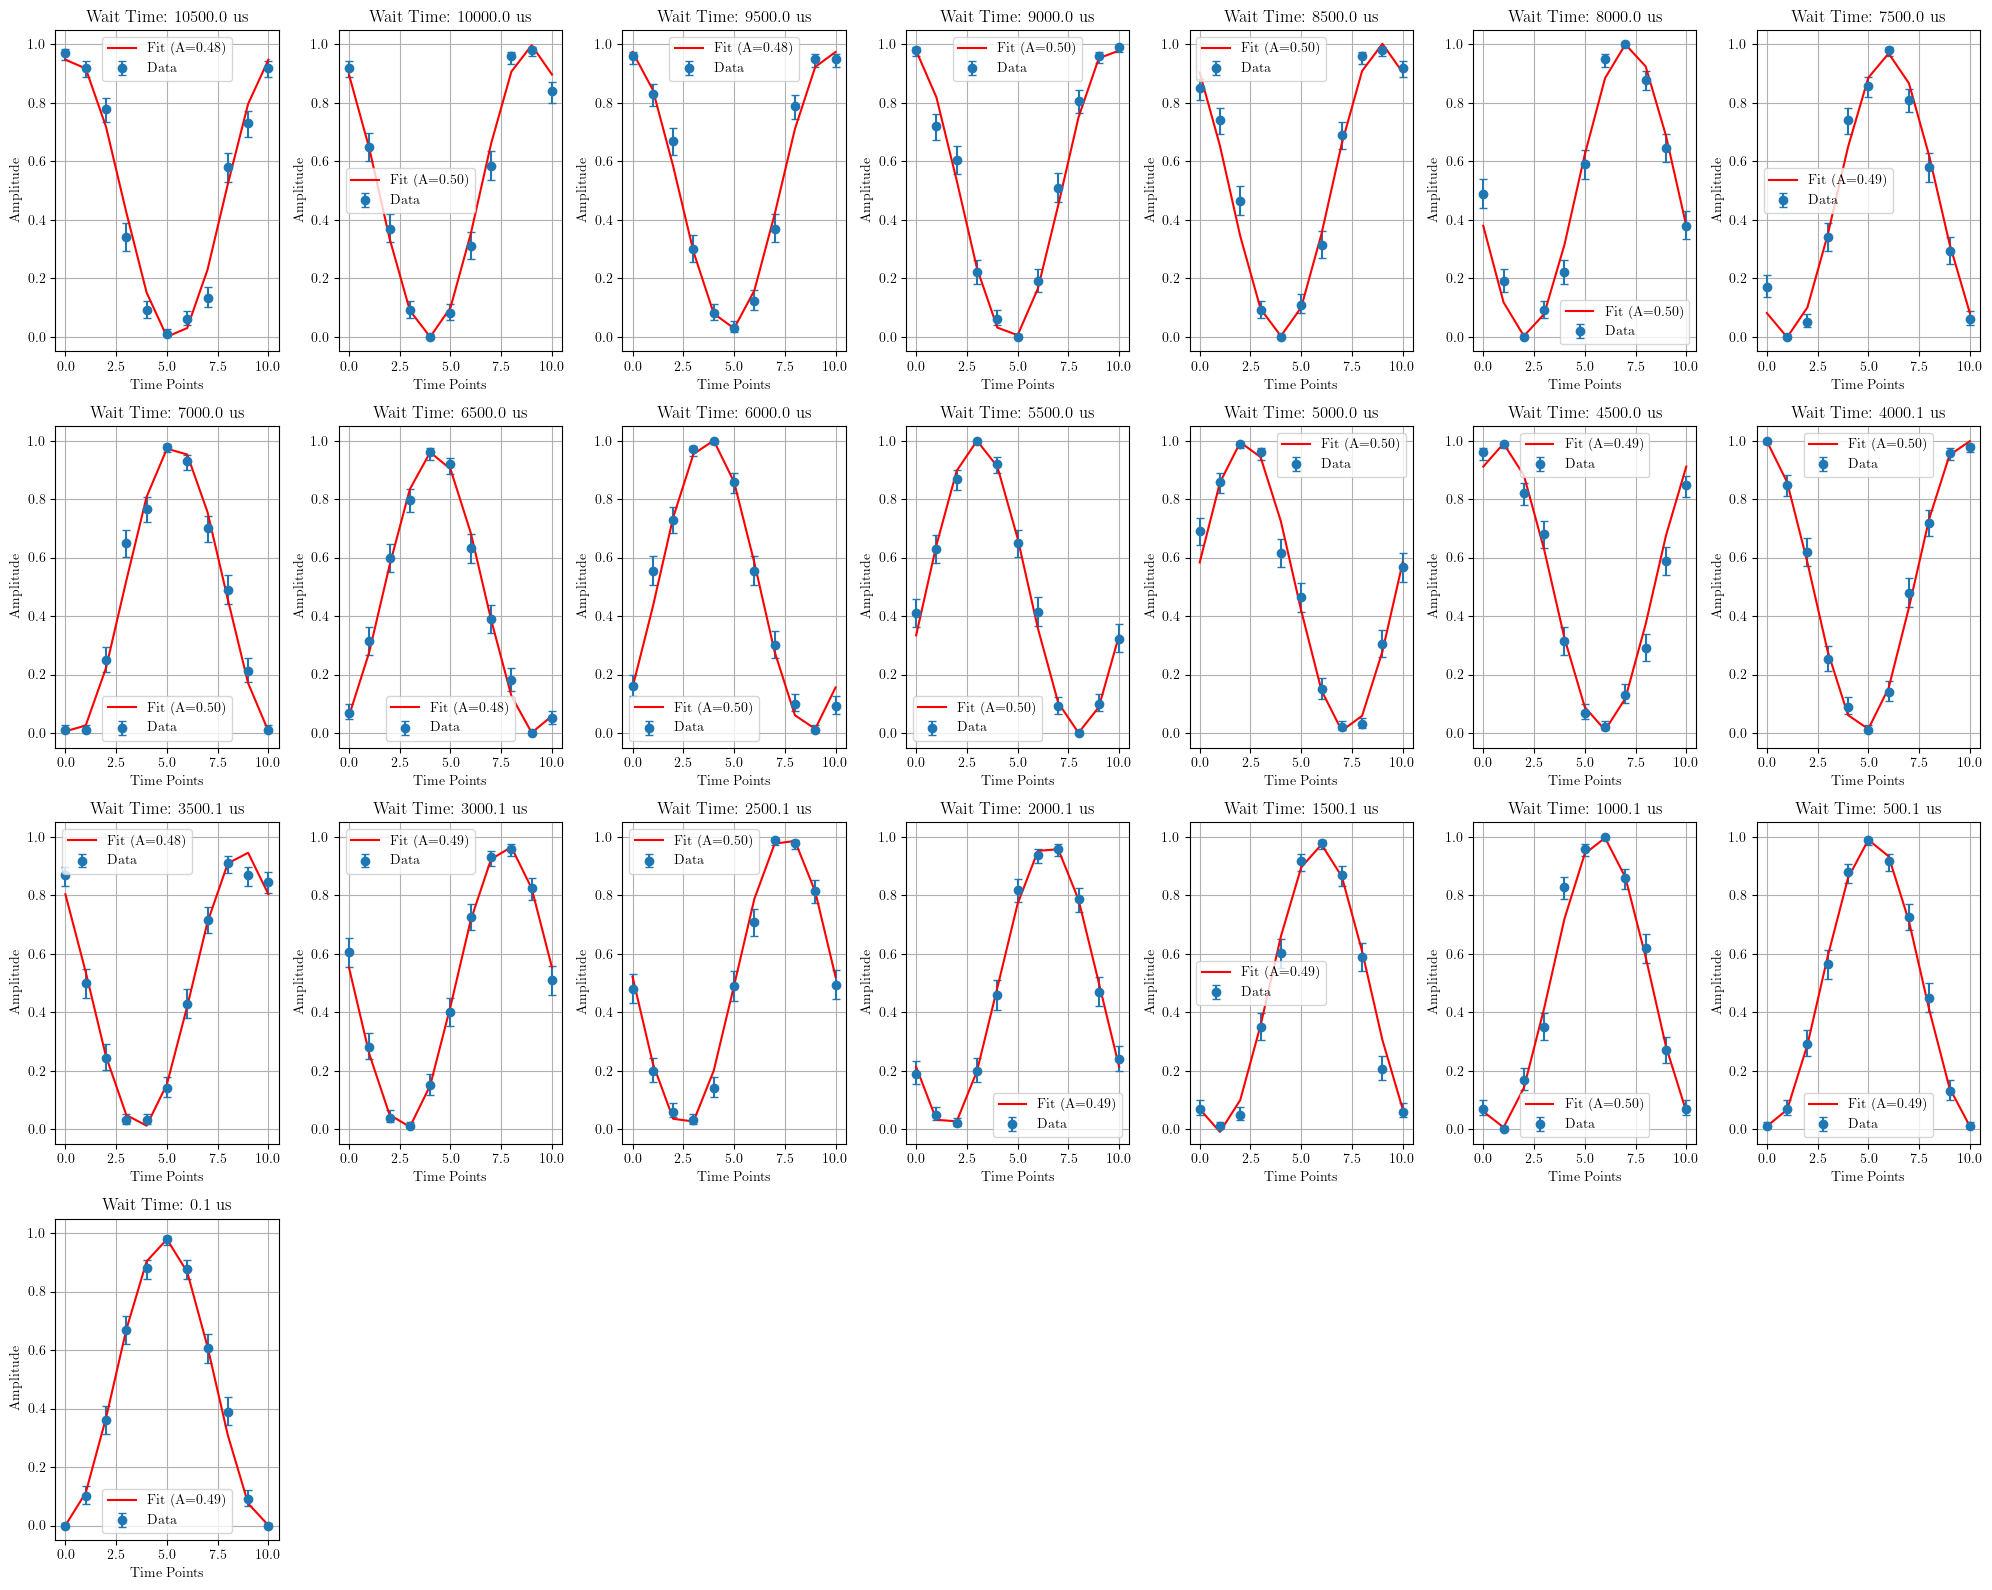


Fitted Results (Lists):
Wait Time: 0.1 us
  Params (A, phi, offset) = 0.490, 6.220, 0.490
  Amplitude (2*|A|) = 0.981 ± 0.013
  Phase = 6.220 ± 0.037
Wait Time: 500.1 us
  Params (A, phi, offset) = 0.494, 0.128, 0.500
  Amplitude (2*|A|) = 0.988 ± 0.013
  Phase = 0.128 ± 0.036
Wait Time: 1000.1 us
  Params (A, phi, offset) = 0.500, 0.490, 0.502
  Amplitude (2*|A|) = 1.000 ± 0.008
  Phase = 0.490 ± 0.031
Wait Time: 1500.1 us
  Params (A, phi, offset) = 0.492, 0.574, 0.483
  Amplitude (2*|A|) = 0.985 ± 0.016
  Phase = 0.574 ± 0.031
Wait Time: 2000.1 us
  Params (A, phi, offset) = 0.487, 0.960, 0.492
  Amplitude (2*|A|) = 0.973 ± 0.020
  Phase = 0.960 ± 0.033
Wait Time: 2500.1 us
  Params (A, phi, offset) = 0.500, 1.601, 0.506
  Amplitude (2*|A|) = 1.000 ± 0.017
  Phase = 1.601 ± 0.030
Wait Time: 3000.1 us
  Params (A, phi, offset) = 0.486, 1.708, 0.487
  Amplitude (2*|A|) = 0.972 ± 0.018
  Phase = 1.708 ± 0.033
Wait Time: 3500.1 us
  Params (A, phi, offset) = 0.475, 2.323, 0.479
  Ampli

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# # Fixed frequency: 2π
# def sine_function(t, A, phi, offset):
#     return A * np.cos(2 * np.pi/10 * t + phi) + offset

# def fit_sine_curve(ket_data, lower_error, upper_error):
#     if len(ket_data) == 5:
#         t = 2*np.arange(len(ket_data))
#     else:
#         t = np.arange(len(ket_data))
#     valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
#     t_valid = t[valid_indices]
#     ket_data_valid = np.array(ket_data)[valid_indices]
#     lower_error_valid = np.array(lower_error)[valid_indices]
#     upper_error_valid = np.array(upper_error)[valid_indices]

#     sigma = (upper_error_valid + lower_error_valid) / 2.0
#     if np.any(sigma <= 0):
#         nonzero = sigma[sigma > 0]
#         replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
#         sigma[sigma <= 0] = replacement

#     initial_guess = [
#         (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
#         0,
#         np.mean(ket_data_valid)
#     ]
#     try:
#         params, covariance = curve_fit(
#             sine_function,
#             t_valid,
#             ket_data_valid,
#             p0=initial_guess,
#             sigma=sigma,
#             absolute_sigma=True, maxfev=10000
#         )
#         if covariance is not None:
#             errors = np.sqrt(np.diag(covariance))
#             errors = [err if np.isfinite(err) else None for err in errors]
#         else:
#             errors = [None] * len(params)

#         return params, errors
#     except RuntimeError:
#         return None, None

def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t - phi - np.pi) + offset

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    A0 = (np.max(ket_data_valid) - np.min(ket_data_valid))/2
    A0 = np.clip(A0, 0.0, 0.5)
    initial_guess = [0.44, np.pi, 0.46]

    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True,
            maxfev=10000,
            bounds=([0.0, 0, 0], [0.5, 2*np.pi*0.99, 1])
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)
        return params, errors
    except RuntimeError:
        return None, None


def fit_all_wait_times_to_sine_in_lists(wait_time_list,
                                        ket_data_list,
                                        lower_error_list,
                                        upper_error_list):
    fit_wait_times_list = []
    fit_params_list = []
    fit_amplitudes_list = []
    fit_amplitude_errors_list = []
    fit_phases_list = []
    fit_phase_errors_list = []
    
    for i in range(len(wait_time_list)):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        if len(kd) > 4:
            params, errors = fit_sine_curve(kd, le, ue)
            if params is not None and errors is not None and errors[0] is not None:
                A, phi, offset = params
                amplitude = 2.0 * abs(A)
                amplitude_error = 2.0 * errors[0] if errors[0] is not None else None
                phase_error = errors[1]

                fit_wait_times_list.append(wt)
                fit_params_list.append(params)
                fit_amplitudes_list.append(amplitude)
                fit_amplitude_errors_list.append(amplitude_error)
                fit_phases_list.append(phi)
                fit_phase_errors_list.append(phase_error)
        else:
            fit_wait_times_list.append(wt)
            fit_params_list.append([None, None, None])
            fit_amplitudes_list.append(None)
            fit_amplitude_errors_list.append(None)
            fit_phases_list.append(None)
            fit_phase_errors_list.append(None)
    return (
        fit_wait_times_list,
        fit_params_list,
        fit_amplitudes_list,
        fit_amplitude_errors_list,
        fit_phases_list,
        fit_phase_errors_list
    )

def plot_sine_fits_in_lists(wait_time_list,
                            ket_data_list,
                            lower_error_list,
                            upper_error_list,
                            fit_wait_times_list,
                            fit_params_list):
    num_plots = len(wait_time_list)
    num_columns = 7
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i in range(num_plots):
        wt = wait_time_list[::-1][i]
        kd = ket_data_list[::-1][i]
        le = lower_error_list[::-1][i]
        ue = upper_error_list[::-1][i]
        
        t = np.arange(len(kd))
        ax = axes[i]
        ax.errorbar(
            t,
            kd,
            yerr=[abs(le), abs(ue)],
            fmt='o',
            label='Data',
            capsize=3
        )
        
        if wt in fit_wait_times_list:
            j = fit_wait_times_list[::-1].index(wt)
            A, phi, offset = fit_params_list[::-1][i]
            if A is not None:
                fit_curve = sine_function(t, A, phi, offset)
                ax.plot(t, fit_curve, color='red', label=f'Fit (A={A:.2f})')

        ax.set_title(f'Wait Time: {wt} us')
        ax.set_xlabel('Time Points')
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Amplitude')
        ax.grid()
        ax.legend()
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig('laser_noise_phase_scans.png', dpi=300)
    plt.show()

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

plot_sine_fits_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    fit_wait_times_list,
    fit_params_list
)

print("\nFitted Results (Lists):")
for i, wt in enumerate(fit_wait_times_list):
    A, phi, offset = fit_params_list[i]
    amp = fit_amplitudes_list[i]
    amp_err = fit_amplitude_errors_list[i]
    phase = fit_phases_list[i]
    phase_err = fit_phase_errors_list[i]
    print(f"Wait Time: {wt} us")
    print(f"  Params (A, phi, offset) = {A:.3f}, {phi:.3f}, {offset:.3f}")
    print(f"  Amplitude (2*|A|) = {amp:.3f} ± {amp_err:.3f}")
    print(f"  Phase = {phase:.3f} ± {phase_err:.3f}")


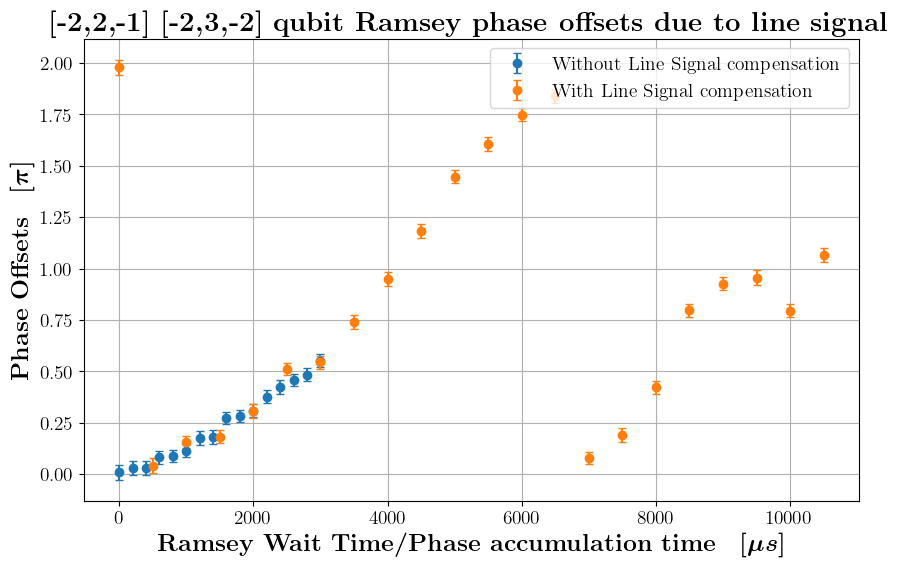

In [146]:
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

plt.figure(figsize=(10, 6))
data = np.loadtxt("phase_offsets_data.txt", comments="#")
time_us = data[:, 0]
phase_over_pi = data[:, 1]
phase_error = data[:, 2]

plt.errorbar(
    time_us,
    phase_over_pi,
    yerr=phase_error,
    fmt='o',
    capsize=3, label='Without Line Signal compensation'
)

plt.errorbar(
    fit_wait_times_list,
    np.array(fit_phases_list)/np.pi,
    yerr=np.array(fit_phase_errors_list),
    fmt='o',
    capsize=3, label='With Line Signal compensation'
)

# print(fit_wait_times_list)
# print(fit_phases_list)
# print(fit_phase_errors_list)

plt.xlabel(r'\boldmath$\textbf{Ramsey Wait Time/Phase accumulation time}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Phase Offsets}\quad [\pi]$', fontsize=18)
plt.title(r'\textbf{[-2,2,-1] [-2,3,-2] qubit Ramsey phase offsets due to line signal}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.savefig('0_2_0_phase_offsets_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
legend = plt.legend(fontsize=14)
plt.show()

In [147]:
# data = np.column_stack([
#     np.array(fit_wait_times_list),
#     np.array(fit_phases_list) / np.pi,
#     np.array(fit_phase_errors_list)
# ])
# np.savetxt(
#     "phase_offsets_data.txt",
#     data,
#     header="time_us phase_over_pi phase_error",
#     fmt="%.8e"
# )

# Theory VS Exp

In [148]:
import numpy as np

import numpy as np
import io

def load_line_fit_parameters(filename):
    B0_fit = None
    B0_err = None
    harmonic_lines = []
    with open(filename, "r") as f:
        for line in f:
            stripped = line.strip()
            if not stripped or stripped.startswith("#"):
                continue
            if B0_fit is None:
                vals = np.fromstring(stripped, sep=" ")
                B0_fit, B0_err = vals[0], vals[1]
            else:
                harmonic_lines.append(stripped)
    harmonics = np.loadtxt(io.StringIO("\n".join(harmonic_lines)))
    if harmonics.ndim == 1:
        harmonics = harmonics[None, :]
    freqs = harmonics[:, 0]
    A = harmonics[:, 1]
    A_err = harmonics[:, 2]
    phi = harmonics[:, 3]
    phi_err = harmonics[:, 4]
    return B0_fit, B0_err, freqs, A, A_err, phi, phi_err


def _get_line_params(param_file, B0, A60, phi60, A180, phi180):
    if param_file is not None:
        B0_fit, B0_err, freqs, A_vals, A_errs, phi_vals, phi_errs = load_line_fit_parameters(param_file)
        return B0_fit, freqs, A_vals, phi_vals
    freqs = np.array([60.0, 180.0], dtype=float)
    A_vals = np.array([A60, A180], dtype=float)
    phi_vals = np.array([phi60, phi180], dtype=float)
    return B0, freqs, A_vals, phi_vals

def B_line_mG(
    t,
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650,
    param_file="line_signal_fit_params.txt"
):
    B0_use, freqs, A_vals, phi_vals = _get_line_params(param_file, B0, A60, phi60, A180, phi180)
    t_arr = np.asarray(t, dtype=float)
    y = np.full_like(t_arr, B0_use, dtype=float)
    for f, A, phi in zip(freqs, A_vals, phi_vals):
        y = y + A * np.cos(2.0 * np.pi * f * t_arr + phi)
    return y

def B_rel_G(
    t,
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650,
    param_file="line_signal_fit_params.txt"
):
    return (B_line_mG(t, B0, A60, phi60, A180, phi180, param_file=param_file)
            - B_line_mG(0.0, B0, A60, phi60, A180, phi180, param_file=param_file)) * 1e-3

def primitive_B_rel_G(
    t,
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650,
    param_file="line_signal_fit_params.txt"
):
    B0_use, freqs, A_vals, phi_vals = _get_line_params(param_file, B0, A60, phi60, A180, phi180)
    t_arr = np.asarray(t, dtype=float)
    t_arr_1d = np.atleast_1d(t_arr)
    omega = 2.0 * np.pi * freqs
    B_line_0 = B0_use + np.sum(A_vals * np.cos(phi_vals))
    const_term = (B0_use - B_line_0) * t_arr_1d
    sin_terms = (A_vals / omega)[:, None] * np.sin(omega[:, None] * t_arr_1d[None, :] + phi_vals[:, None])
    F_mG = const_term + np.sum(sin_terms, axis=0)
    F_Gs = 1e-3 * F_mG
    if np.isscalar(t):
        return float(F_Gs[0])
    return F_Gs

def integral_B_rel_G(
    t_start,
    t_end,
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650,
    param_file="line_signal_fit_params.txt"
):
    F_end = primitive_B_rel_G(t_end, B0, A60, phi60, A180, phi180, param_file=param_file)
    F_start = primitive_B_rel_G(t_start, B0, A60, phi60, A180, phi180, param_file=param_file)
    return F_end - F_start

def compute_pi_times(pi_t):
    transition_strengths = np.loadtxt(
        'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\Transition_strengths_4p216.txt',
        delimiter=','
    )
    transition_strengths[transition_strengths == 0] = np.nan
    strengths = np.array([
        transition_strengths[22, 1],
        transition_strengths[14, 0],
        transition_strengths[5, 2],
        transition_strengths[16, 4],
        transition_strengths[15, 4]
    ])
    factors = np.array(pi_t) * strengths
    Fs = [1, 2, 3, 4]
    row_labels = [[i, i - j] for i in Fs for j in range(2 * i + 1)]
    col_labels = [-2, -1, 0, 1, 2]
    pi_times = np.zeros((24, 5))
    for i in range(np.shape(transition_strengths)[0]):
        for j in range(np.shape(transition_strengths)[1]):
            if not np.isnan(transition_strengths[i, j]):
                delta_m = (row_labels[i][1] - col_labels[j]) + 2
                pi_times[i, j] = factors[delta_m] / transition_strengths[i, j]
    return pi_times

def get_pi_times_from_matrix(transitions, matrix):
    Fs = [1, 2, 3, 4]
    states = []
    for i in Fs:
        for j in range(2 * i + 1):
            mF = i - j
            states.append([i, mF])
    row_labels = states
    col_labels = [-2, -1, 0, 1, 2]
    pi_times_list = []
    for transition in transitions:
        row_label = [transition[1], transition[2]]
        col_label = transition[0]
        row_index = next((k for k, label in enumerate(row_labels) if label == row_label), None)
        col_index = col_labels.index(col_label) if col_label in col_labels else None
        if row_index is not None and col_index is not None:
            pi_times_list.append(matrix[row_index, col_index])
        else:
            pi_times_list.append(np.nan)
    return pi_times_list

def get_pulse_schedule(rabi_freqs, fractions):
    if len(rabi_freqs) != len(fractions):
        raise ValueError(f"rabi_freqs {len(rabi_freqs)} and fractions {len(fractions)} must have the same length.")
    times = []
    t_current = 0.0
    for Omega, frac in zip(rabi_freqs, fractions):
        if not 0 <= frac <= 1:
            raise ValueError(f"Fraction must be between 0 and 1, got {frac}.")
        theta = 2.0 * np.arcsin(np.sqrt(frac))
        t_pulse = theta / Omega if Omega > 0 else 0.0
        t_start = t_current
        t_end = t_current + t_pulse
        times.append((t_start, t_end))
        t_current = t_end
    return times

def compute_phases_from_line_signal(
    pulse_train,
    fractions,
    pi_t=[23.76, 36.54, 106.33, 32.755, 39.168],
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650,
    param_file="line_signal_fit_params.txt"
):
    pulse_train = [tuple(tr) for tr in pulse_train]
    pi_times_matrix = compute_pi_times(pi_t)
    pi_times_train = get_pi_times_from_matrix(pulse_train, pi_times_matrix)
    for i, tr in enumerate(pulse_train):
        if tr == (0, 0, 0):
            pi_times_train[i] = 1e6
    rabi_frequencies_list = np.pi / np.array(pi_times_train)
    schedule_us = get_pulse_schedule(rabi_frequencies_list, fractions)
    pulses_sec = [(start * 1e-6, end * 1e-6) for (start, end) in schedule_us]
    sens_matrix = np.loadtxt(
        'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\sensitivities_4p216.txt',
        delimiter=','
    )
    sens_list = get_pi_times_from_matrix(pulse_train, sens_matrix)
    for i, tr in enumerate(pulse_train):
        if tr == (0, 0, 0):
            sens_list[i] = 0.0
    sens_array = np.array(sens_list, dtype=float)
    transition_intervals = {}
    free_intervals = []
    for idx, (tr, (t_start, t_end)) in enumerate(zip(pulse_train, pulses_sec)):
        if tr == (0, 0, 0):
            free_intervals.append((t_start, t_end))
        else:
            if tr not in transition_intervals:
                transition_intervals[tr] = []
            transition_intervals[tr].append({"t_start": t_start, "t_end": t_end, "idx": idx})
    all_ends = [t_end for (_, t_end) in free_intervals]
    for intervals in transition_intervals.values():
        all_ends += [iv["t_end"] for iv in intervals]
    if len(all_ends) == 0:
        return None
    phases_per_pulse = np.zeros(len(pulse_train), dtype=float)
    for tr, intervals in transition_intervals.items():
        intervals_sorted = sorted(intervals, key=lambda iv: iv["t_start"])
        mids = [0.5 * (iv["t_start"] + iv["t_end"]) for iv in intervals_sorted]
        if len(mids) > 1:
            for j in range(len(mids) - 1):
                mid_prev = mids[j]
                mid_cur = mids[j + 1]
                idx_cur = intervals_sorted[j + 1]["idx"]
                y_horiz = B_rel_G(mid_prev, B0, A60, phi60, A180, phi180, param_file=param_file)
                area_Gs = (integral_B_rel_G(
                    mid_prev,
                    mid_cur,
                    B0,
                    A60,
                    phi60,
                    A180,
                    phi180,
                    param_file=param_file
                ) - (mid_cur - mid_prev) * y_horiz)
                phase_rad = 2.0 * np.pi * 1e6 * sens_array[idx_cur] * area_Gs
                phases_per_pulse[idx_cur] = phase_rad
    return phases_per_pulse.tolist()


In [163]:
accm_phase = []
for i in np.arange(0, 16800, 500):
    pulse_train = [[-2,2,-1], [-2,3,-2], [0,0,0],  [-2,3,-2],[-2,2,-1]]
    fractions = [0.5,1,(np.sin((i/1e6)*(np.pi/2)))**2,1,0.5]
    phases = compute_phases_from_line_signal(pulse_train, fractions)
    accm_phase.append(phases[3]-phases[4])

phase_mod = np.mod(np.array(accm_phase), 2*np.pi)/np.pi
    

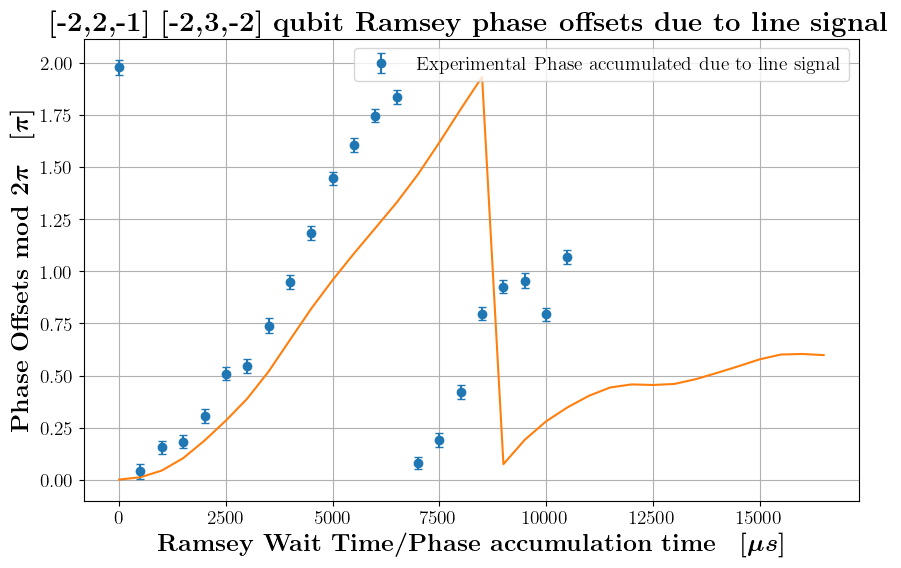

In [164]:
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

plt.figure(figsize=(10, 6))
data = np.loadtxt("phase_offsets_data.txt", comments="#")
time_us = data[:, 0]
phase_over_pi = data[:, 1]
phase_error = data[:, 2]

# plt.errorbar(
#     time_us,
#     phase_over_pi,
#     yerr=phase_error,
#     fmt='o',
#     capsize=3, label='Without Line Signal compensation'
# )

plt.errorbar(
    fit_wait_times_list,
    np.array(fit_phases_list)/np.pi,
    yerr=np.array(fit_phase_errors_list),
    fmt='o',
    capsize=3, label='Experimental Phase accumulated due to line signal'
)

plt.plot(np.arange(0, 16800, 500), phase_mod)

# print(fit_wait_times_list)
# print(fit_phases_list)
# print(fit_phase_errors_list)

plt.xlabel(r'\boldmath$\textbf{Ramsey Wait Time/Phase accumulation time}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Phase Offsets mod 2}\pi \quad [\pi]$', fontsize=18)
plt.title(r'\textbf{[-2,2,-1] [-2,3,-2] qubit Ramsey phase offsets due to line signal}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
# plt.savefig('0_2_0_phase_offsets_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
legend = plt.legend(fontsize=14)
plt.show()